In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import joblib
from tqdm import tqdm
import pandas as pd
import argparse
import os
from scipy.stats import ortho_group

In [2]:
from main import weighted_l2, decode, PSNR, plot_data, load_ecg, load_train_ecg, load_test_ecg, create_pulse
max_signal_length = 100 # used in load_train_ecg and load_test_ecg to keep an integer multiple of patch_size number of samples  

In [3]:
# default values
# cnt is the number of plots to be saved for each (n_components, n_train, patch_size) tuple 
n_train, n_test, n_components, cnt = 10000, 1000, 5, 5
n_init, d, to_train, use_mat = 5, 30, True, False # d is the patch size

# for pulse
num_peaks = d//10
peak_width = 10

folder_name = 'results/n_components=%d,n_train=%d,patch_size=%d/' % (n_components, n_train, d)

In [4]:
def generate_covariance_matrices(n_components, d):
    ans = []
    for i in range(n_components):
        # k = (d//3) * 2 # something lesser than d
        # W = np.random.rand(d,k)
        # S = (W @ W.transpose()) + np.diag(np.random.rand(1,d) * 0.01)
        # S = np.diag(1/np.sqrt(np.diag(S))) @ S @ np.diag(1/np.sqrt(np.diag(S)))
        # ans.append(S)
        Q = ortho_group.rvs(d)
        decay = 0.47*(1 + np.random.random())
        eps = 1e-8
        U = np.ones(d,) * (np.random.rand() * 20) + 600
        for j in range(1,d):
            U[j] = max((U[j-1] * decay) + (np.random.rand() * 0.01), eps)
        ans.append(Q @ np.diag(U) @ Q.transpose())
    return np.array(ans)

In [5]:
gen_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

gen_model.weights_ = np.random.rand(n_components,)
gen_model.weights_ /= np.sum(gen_model.weights_)

gen_model.means_ = np.random.rand(n_components, d) * 80
gen_model.covariances_ = generate_covariance_matrices(n_components, d)

[0.37162927 0.08739397 0.06845295 0.39657998 0.07594384]
(5,)
(5, 30)
(5, 30, 30)


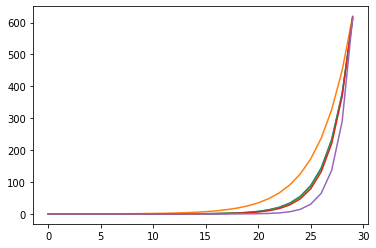

In [6]:
print(gen_model.weights_) # check if no single component gets majority of the weight 
print(gen_model.weights_.shape)
print(gen_model.means_.shape)
print(gen_model.covariances_.shape)

# sanity check of covariance matrix
for i in range(n_components):
    # asserting checks if matrix is positive definite
    assert(np.linalg.det(gen_model.covariances_[i,:,:]) > 0)
    plt.plot(np.linalg.eigvalsh(gen_model.covariances_[i,:,:]))
    
plt.show()

In [7]:
train_data,_ = gen_model.sample(n_train)
train_data.shape

(10000, 30)

In [8]:
# here one assumption is that we know the number of components, however this will have to be varied
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
model.fit(train_data)

if os.path.isdir(folder_name):
    for f in os.listdir(folder_name):
        if not os.path.isdir(folder_name + f):
            os.remove(folder_name + f)
else:
    os.makedirs(folder_name)

# Save the model as a pickle in a file
joblib.dump(model, folder_name + 'model.pkl')

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
Initialization converged: True


['results/n_components=5,n_train=10000,patch_size=30/model.pkl']

In [9]:
test_data,_ = gen_model.sample(n_test)
A_ = np.random.binomial(1, 0.5, size=(d, d))

ms = [d*(i+1)//10 for i in range(10)]
psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
val_err, err_std = [], []

for m in tqdm(ms):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    reconstruction = np.empty(test_data.shape)
    patch_err = []
    cnt1 = cnt
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
        # cs example
        if cnt1 > 0:
            plt.plot(x, label='Original', color = "C0")
            plt.plot(x_hat, label='Reconstructed', color = "C1")
            plt.legend()
            plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
            plt.close()
            cnt1 -= 1
        reconstruction[j] = x_hat
    val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    psnr.append(val)
    psnr_min.append(min_val)
    psnr_max.append(max_val)
    psnr_std.append(std_val)
    val_err.append(np.mean(patch_err))
    err_std.append(np.std(patch_err))

print(psnr)
print(psnr_std)
print(val_err)
print(err_std)
plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')

100%|██████████| 10/10 [01:29<00:00,  8.99s/it]


[23.58167723886393, 30.373326283633368, 36.052563414992676, 38.37666878369475, 43.4081863682439, 46.69326101519857, 50.89400191400436, 54.33492391088502, 56.64007511320169, 60.85004307562551]
[8.194625800613261, 4.896595458373416, 4.68265070583671, 5.076311167941359, 5.095889132250019, 5.002660623636205, 5.295696707415824, 5.404533166467884, 5.092871322273042, 5.257774400688657]
[18.975392704315617, 25.31545338382489, 5.880927629200187, 8.596495697708631, 5.129067276631292, 3.9266338037449886, 3.3201699407102354, 2.503797911172992, 1.7134536315010116, 0.8978426605022328]
[19.82497342791997, 38.01016282105712, 4.484549996874701, 7.41003868849535, 4.0679721473058, 2.8399249685209136, 3.111575282245576, 2.590504282835066, 1.431404604138801, 0.809250695028435]


# The following section would be to detect anomalies in the y domain
- we can use val error which is the mean of cross val errors for each measurent length
- let us detect drift based on the following condition

If 20 or more consecutive samples lie outside $E[e_{cv}] + 0.5V[e_{cv}]$ we will conclude that there is a drift in the generating distribution

10it [01:10,  7.01s/it]


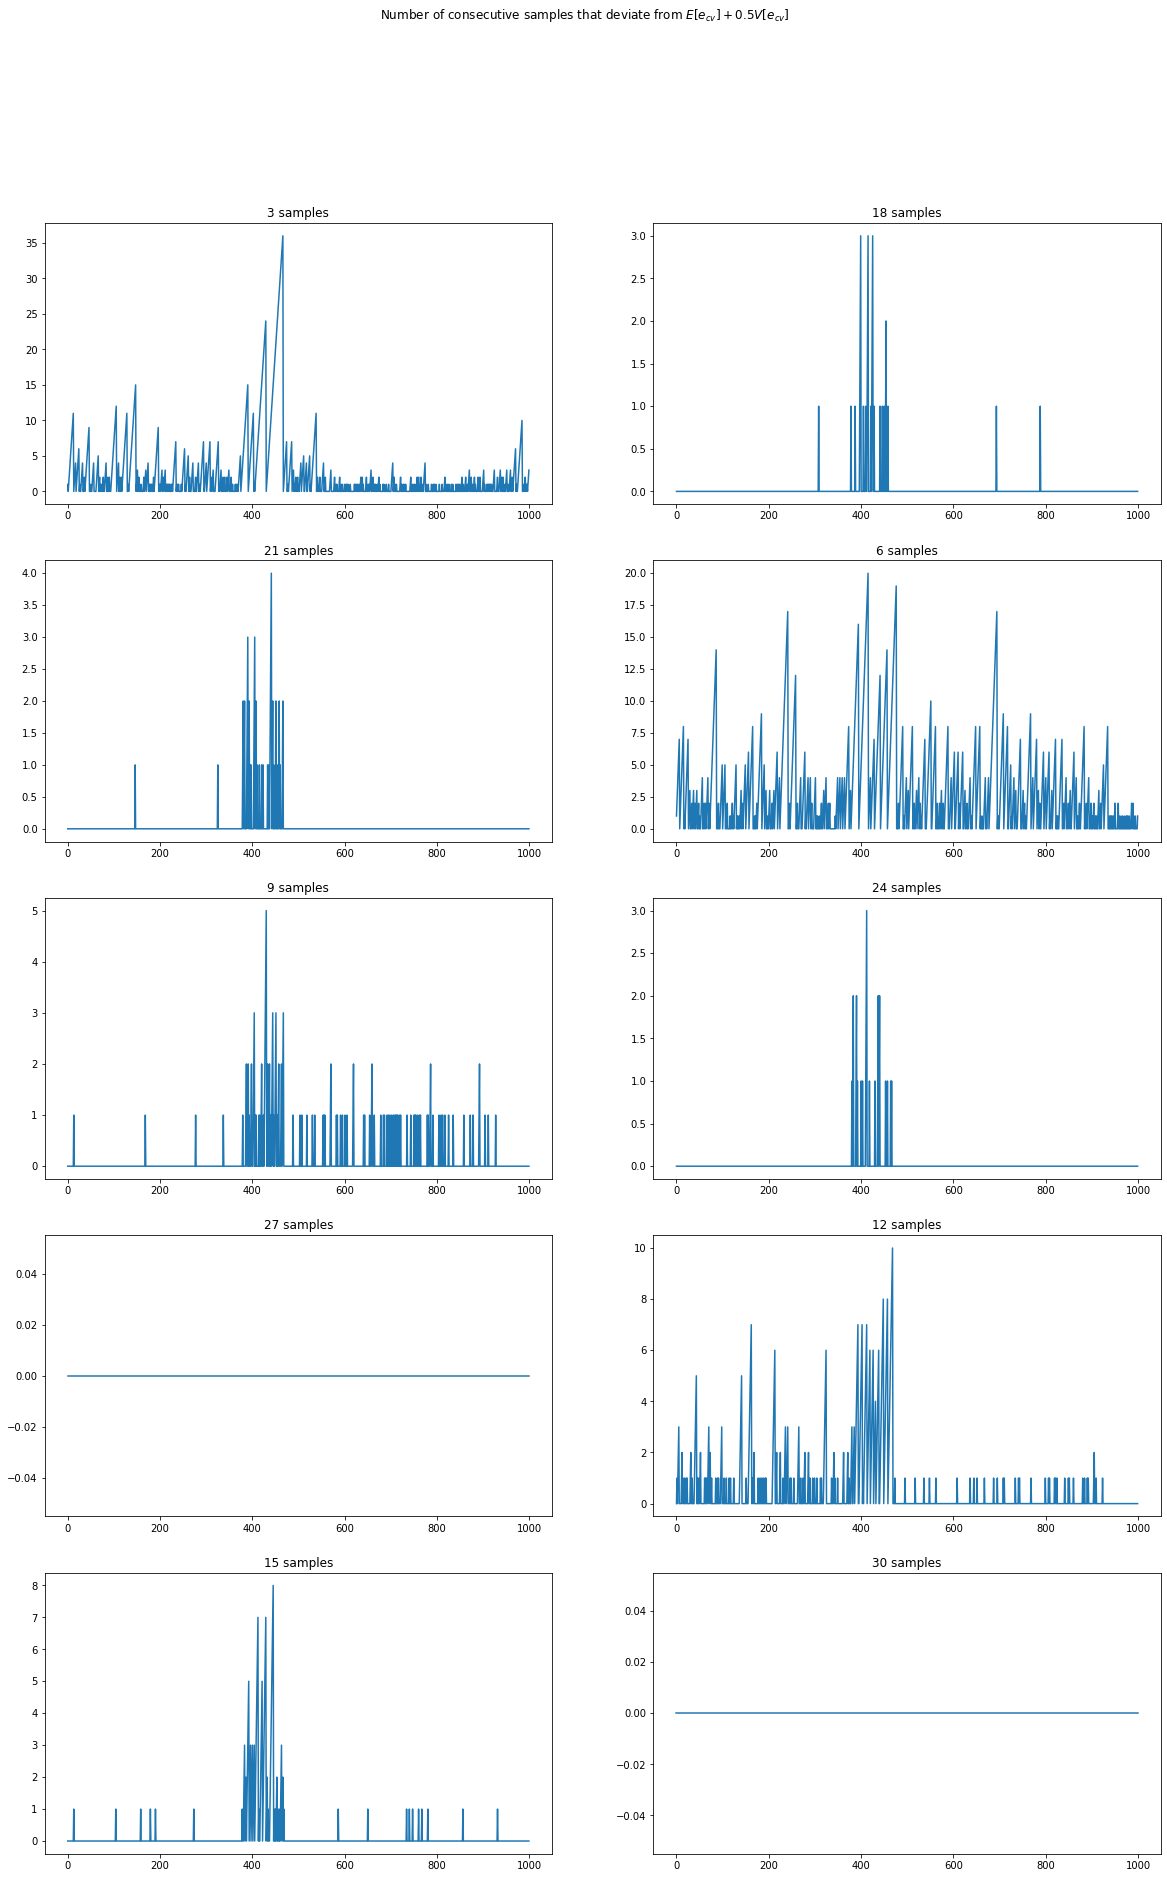

In [10]:
test_data,_ = gen_model.sample(n_test)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Number of consecutive samples that deviate from $E[e_{cv}] + 0.5V[e_{cv}]$")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    dev_counts = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (patch_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            dev_counts.append(deviation_count)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(dev_counts)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

# Observation
We observe that unless the number of measurements is too low (10%), it is very rare that the number of consecutive samples that deviate from <br> $E[e_{cv}] + 0.5V[e_{cv}]$ would be greater than 20. Hence, we can use this as a criteria to detect drift <br>
The following section intends to introduce a drift in the generating distribution intentionally to check whether our criteria was correct

In [11]:
# introduction on drift in the generating distribution
drift_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

drift_model.weights_ = gen_model.weights_
drift_model.means_ = gen_model.means_ * (np.random.rand()*0.4 + 0.8)
drift_model.covariances_ = generate_covariance_matrices(n_components, d)

10it [01:07,  6.77s/it]


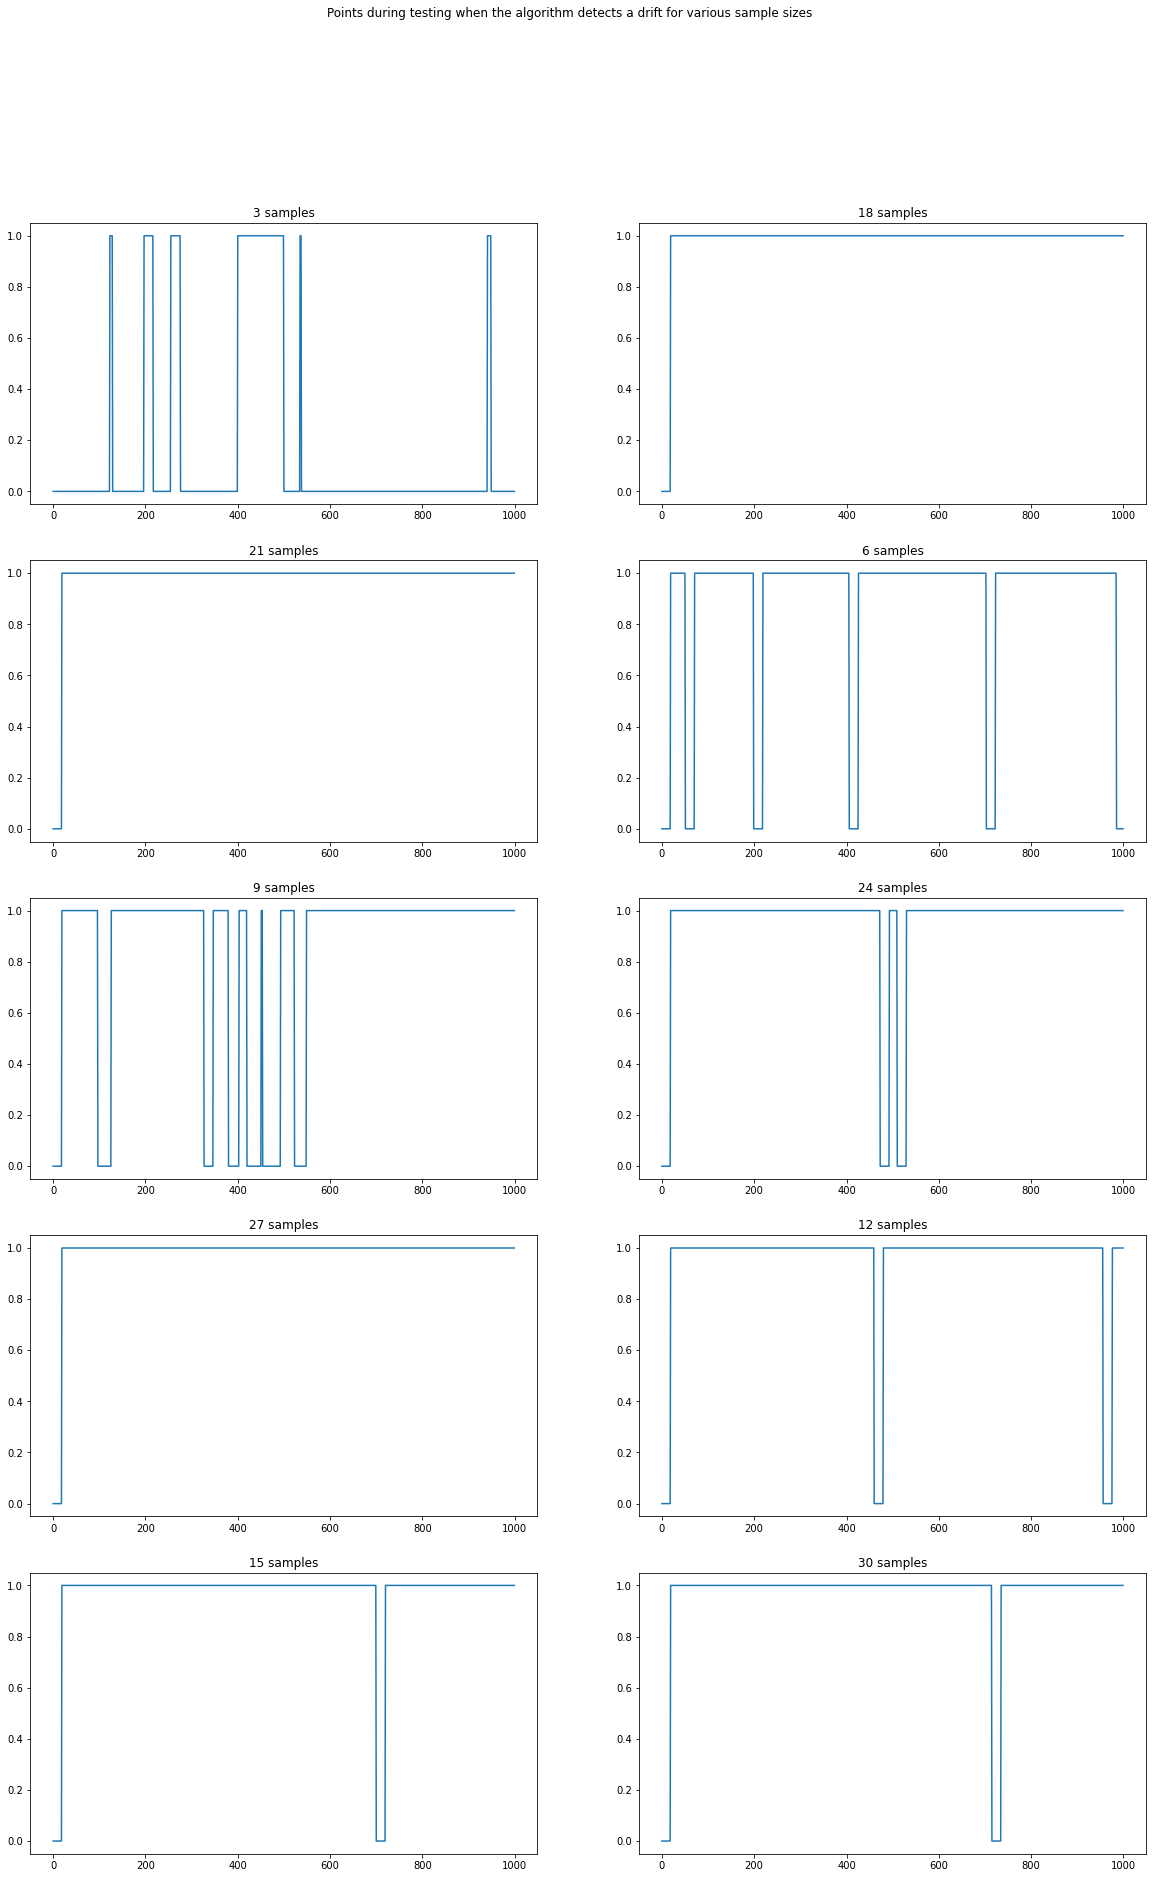

In [13]:
test_data,_ = drift_model.sample(n_test)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Points during testing when the algorithm detects a drift for various sample sizes")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    flagged = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (patch_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            if(deviation_count >= 20):
                flagged.append(1)
            else:
                flagged.append(0)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(flagged)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

Hence we observe that we almost always are able to detect a drift with the given method